In [2]:
%config Completer.use_jedi = False
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

In [3]:
A = np.array([[-1,0,0,0],[0,-1,0,0],[1,0,0,0],[0,1,0,0]])
B = np.array([[1,0],[0,1],[0,0],[0,0]])
I = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
Te = 0.01
F = I+A*Te
G = B*Te

# Drone State Space Equations
def DroneSys(xk,uk):
    xk = np.resize(xk,(4,1))
    uk = np.resize(uk,(2,1))
    return F@xk + G@uk

In [4]:
N = 1000

# Simulation
def Simul(sys,U):
    X = np.ones((4,N))*0
    for i in range(N-1):
        X[:,i+1] = sys(X[:,i],U[:,i]).T
    t = np.arange(N)*Te
    plt.figure()
    plt.title('x')
    plt.plot(t,X[0,:])
    plt.plot(t,U[0,:])
    plt.figure()
    plt.title('y')
    plt.plot(t,X[1,:])
    plt.plot(t,U[1,:])

<IPython.core.display.Javascript object>


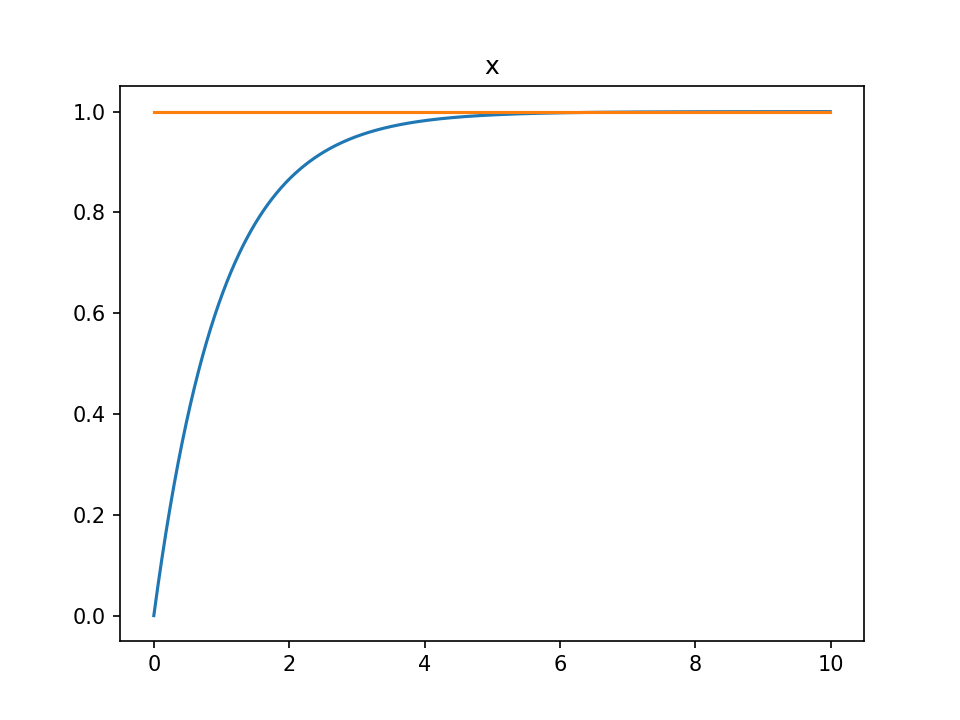

<IPython.core.display.Javascript object>


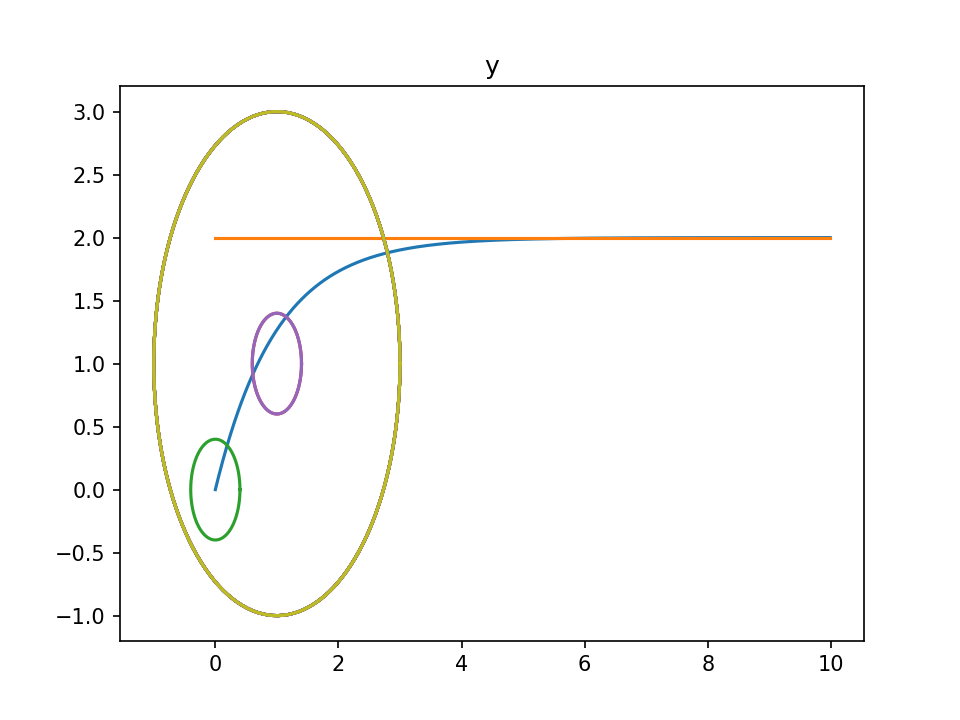

In [4]:
U = np.array([np.ones(N),np.ones(N)*2])
Simul(DroneSys,U)

In [32]:
kl = 1

# Region parameters
r1 = 1
xo1 = 0
yo1 = 0

rc = 2 # Proximity radius limit

alpha = 1
gamma = 1

def PlotCircle(r,x0,y0):
    angle = np.linspace( 0 , 2 * np.pi , 150 )
    x = r * np.cos( angle ) + x0
    y = r * np.sin( angle ) + y0
    plt.plot( x, y )

circle = lambda r, xi, yi, xj, yj : r**2 - (xi - xj)**2 - (yi - yj)**2
    
def gof_circle(r,xi,yi,xj,yj):
    return max([0, -circle(r,xi,yi,xj,yj)])

def gof_ccircle(r,xi,yi,xj,yj):
    return max([0, circle(r,xi,yi,xj,yj)])

f_circle = lambda xi, yi : gof_circle(r1,xi,yi,xo1,yo1)

def DeltaXi(xi,yi,xj,yj):
    return kl*f_circle(xi,yi)*np.array([[2*(xi - xj)],
                                        [2*(yi - yj)]])

def DeltaRho(xi,yi,xj,yj):
    return kl*gof_ccircle(rc,xi,yi,xj,yj)*np.array([[-2*(xi - xj)],
                                                    [-2*(yi - yj)]])


<IPython.core.display.Javascript object>


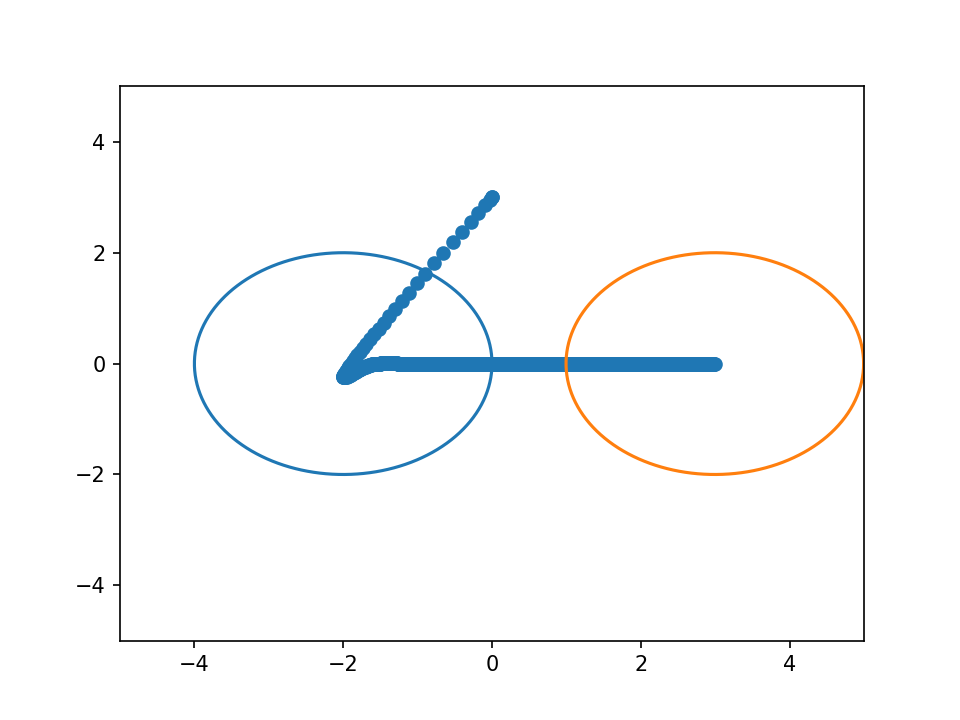

<IPython.core.display.Javascript object>


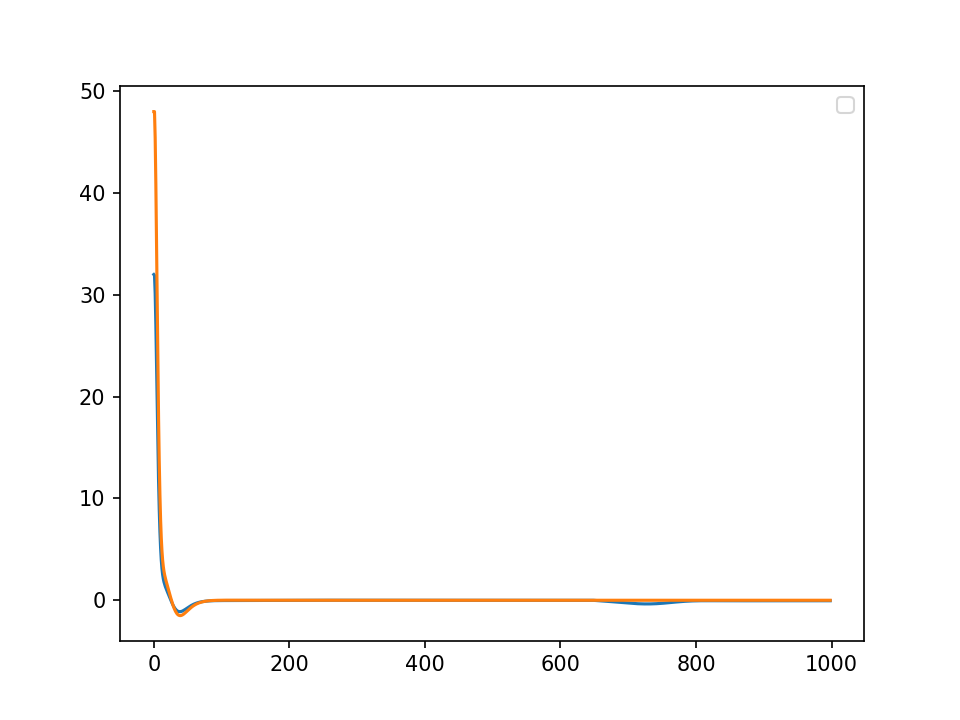

<IPython.core.display.Javascript object>


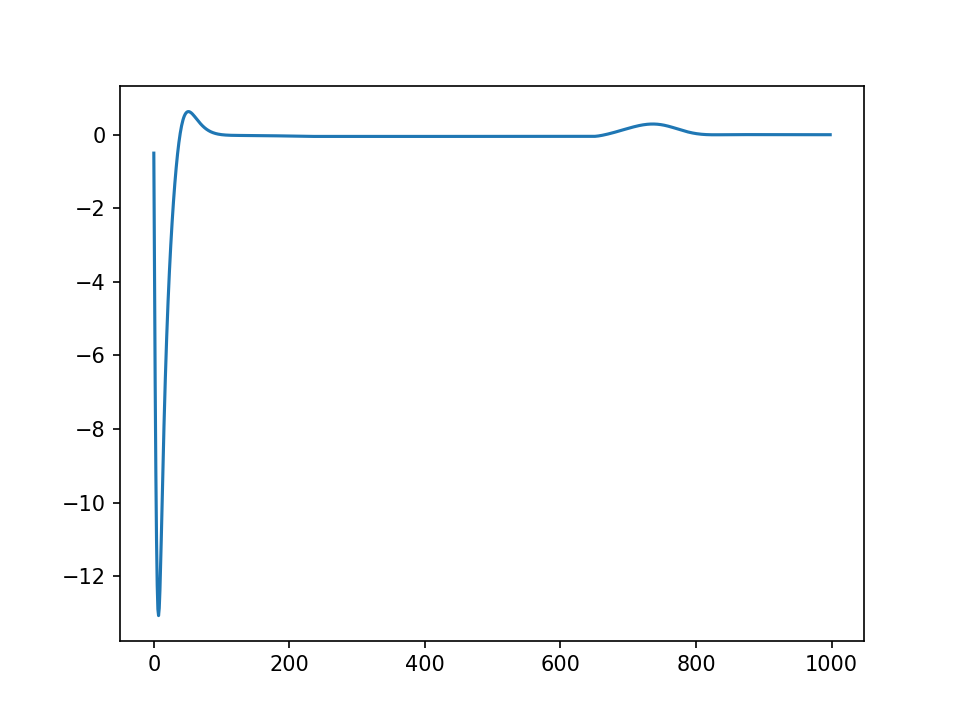

In [39]:
N = 1000
Ksi = 10
Kp = .5
lim = 5

# Simulation
def Simul2D(sys,ref):
    X = np.array([np.ones(N)*0,
                  np.ones(N)*0,
                  np.ones(N)*0,
                  np.ones(N)*3])
    U = np.ones((2,N))*0
    Eps = np.ones((2,N-1))*0
    CircleCenter = np.array([np.ones(N)*-2,np.ones(N)*0])
    temp = np.ones((2,N-1))*0
    
    for i in range(N-1):
        deltaXi = DeltaXi(X[2,i],X[3,i],CircleCenter[0,i],CircleCenter[1,i])
        deltaRho = DeltaRho(X[2,i],X[3,i])
        eps = alpha*deltaXi + deltaRho
        si = np.reshape(X[0:2,i],(2,1)) - np.reshape(ref[:,i],(2,1)) + eps
        
        temp[:,i] = X[0:2,i] - ref[:,i]
        
        u = -Ksi*si - Kp*eps
        
        Eps[:,i] = eps.T
        CircleCenter[:,i+1]  = CircleCenter[:,i] + ref[:,i]*Te
        U[:,i] = u.T
        X[:,i+1] = sys(X[:,i],u).T
        
    plt.figure()
    plt.scatter(X[2,:],X[3,:])
    PlotCircle(rc,CircleCenter[0,0],CircleCenter[1,0])
    PlotCircle(rc,CircleCenter[0,-1],CircleCenter[1,-1])
    plt.xlim([-lim,lim])
    plt.ylim([-lim,lim])
    
    plt.figure()
    plt.legend(["Xi x", "Xi y"])
    plt.plot(Eps[0,:])
    plt.plot(Eps[1,:])
    
    plt.figure()
    plt.plot(temp[0,:])

ref = np.array([np.ones(N)*.5,np.ones(N)*.0])
Simul2D(DroneSys,ref)